### Import Libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import os
from kaggle.api.kaggle_api_extended import KaggleApi


We import TensorFlow for deep learning, Matplotlib and Seaborn for plotting graphs, and other essentials for building and training the model.

In [3]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download dataset
api.dataset_download_files('shahriar26s/malaria-detection', path='.', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/shahriar26s/malaria-detection


### Prepare the Data

In [18]:
# Normalize the images (rescale pixel values to [0,1])
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the images
train_data = train_datagen.flow_from_directory('Malaria Dataset/train', target_size=(224,224), batch_size=32, class_mode='binary')
valid_data = valid_datagen.flow_from_directory('Malaria Dataset/valid', target_size=(224,224), batch_size=32, class_mode='binary')
test_data = test_datagen.flow_from_directory('Malaria Dataset/test', target_size=(224,224), batch_size=32, class_mode='binary')


Found 13152 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


ImageDataGenerator rescales pixel values from 0–255 to 0–1 (important for faster training).

flow_from_directory automatically labels images based on folder names.

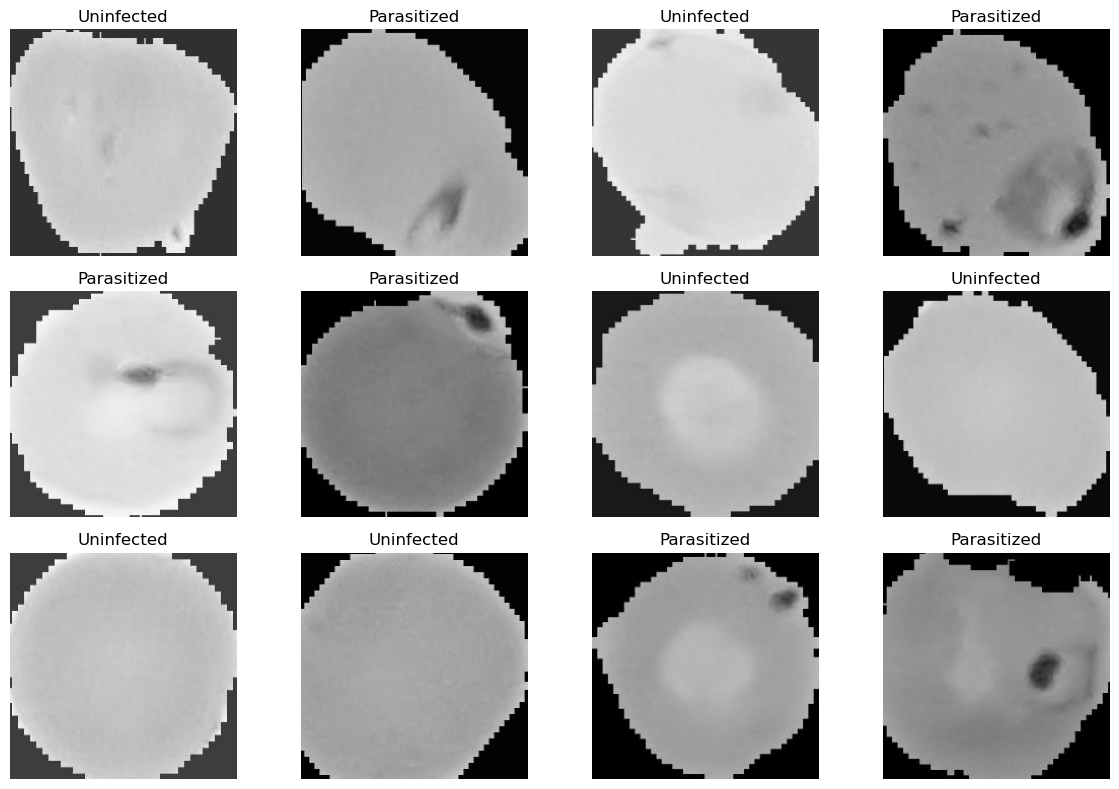

In [19]:
# Grab a batch of images and labels
images, labels = next(iter(train_data))

# Plot some of them
plt.figure(figsize=(12, 8))

for i in range(12):  # Show 12 images
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i])
    plt.title('Parasitized' if labels[i]==0 else 'Uninfected')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Build a CNN Model

In [20]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),    # helps prevent overfitting
    Dense(1, activation='sigmoid') # Binary output: infected or uninfected
])


Conv2D: Extracts features from the image.

MaxPooling2D: Downsamples the feature maps.

Flatten: Converts the 2D data into 1D.

Dense: Fully connected layers for final prediction.

Dropout: Randomly ignores 50% neurons to prevent overfitting.

Sigmoid Activation: Because this is a binary classification (infected/uninfected).

### Compile the Model

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Adam: Adaptive optimizer (smart gradient descent).

Binary Crossentropy: Ideal loss function for binary classification.

Accuracy: We want to monitor how well it predicts.

### Add Early Stopping

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


If the model's validation loss doesn’t improve for 3 epochs, it stops automatically.

Saves time and avoids overfitting.

### Train the Model

In [23]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
411/411 [==============================] - 903s 2s/step - loss: 0.7015 - accuracy: 0.5639 - val_loss: 0.6571 - val_accuracy: 0.6457
Epoch 2/15
411/411 [==============================] - 839s 2s/step - loss: 0.6563 - accuracy: 0.6137 - val_loss: 0.6304 - val_accuracy: 0.6616
Epoch 3/15
411/411 [==============================] - 1067s 3s/step - loss: 0.5977 - accuracy: 0.6852 - val_loss: 0.4459 - val_accuracy: 0.7622
Epoch 4/15
411/411 [==============================] - 873s 2s/step - loss: 0.3375 - accuracy: 0.8642 - val_loss: 0.2362 - val_accuracy: 0.9202
Epoch 5/15
411/411 [==============================] - 706s 2s/step - loss: 0.2307 - accuracy: 0.9198 - val_loss: 0.2320 - val_accuracy: 0.9234
Epoch 6/15
411/411 [==============================] - 717s 2s/step - loss: 0.1755 - accuracy: 0.9414 - val_loss: 0.2458 - val_accuracy: 0.9194
Epoch 7/15
411/411 [==============================] - 758s 2s/step - loss: 0.1308 - accuracy: 0.9545 - val_loss: 0.2556 - val_accuracy: 0.922

15 epochs should be good, but early stopping might stop it earlier if no improvement.

It trains on train_data and checks performance on valid_data every epoch.

### Plot Accuracy and Loss Curves

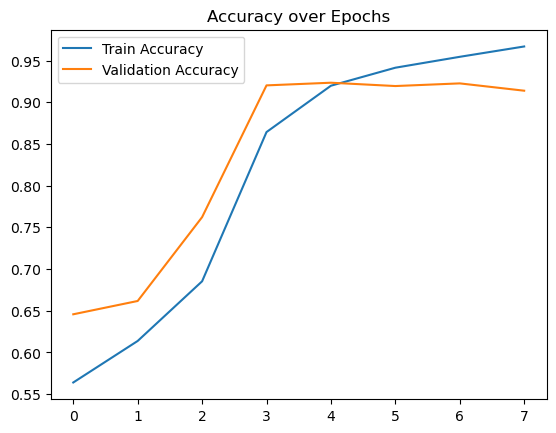

In [24]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

Helps you visually see if the model is learning properly (and not overfitting).

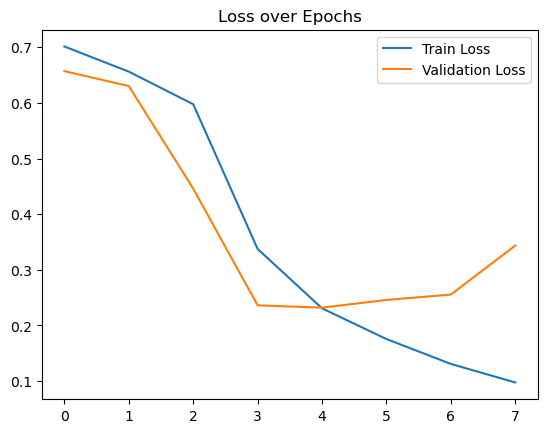

In [25]:
# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

20/20 [==============================] - 10s 505ms/step
              precision    recall  f1-score   support

           0       0.47      0.43      0.45       309
           1       0.49      0.53      0.51       317

    accuracy                           0.48       626
   macro avg       0.48      0.48      0.48       626
weighted avg       0.48      0.48      0.48       626



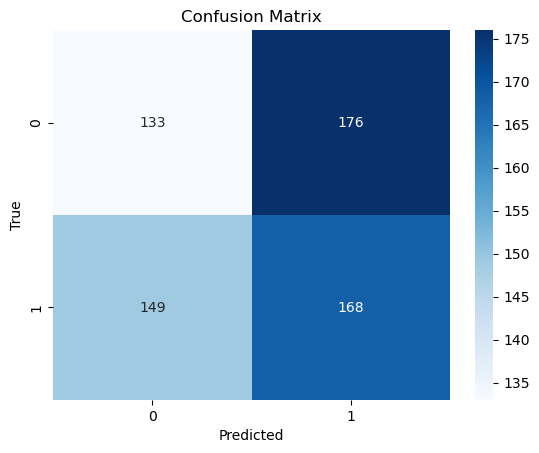

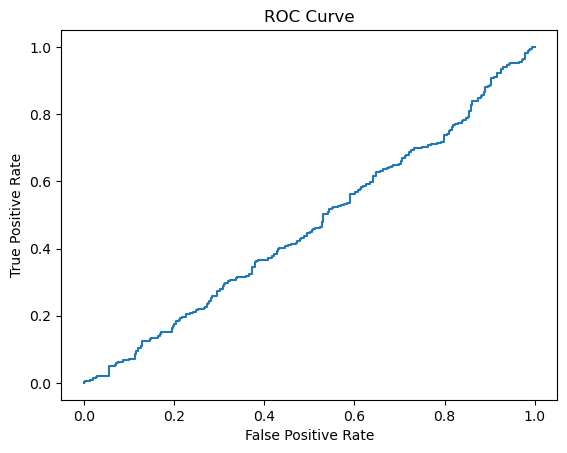

ROC-AUC Score: 0.46802037711963906


In [26]:
# Predict
y_pred_probs = model.predict(test_data)
y_pred = (y_pred_probs > 0.5).astype("int32")

# True labels
y_true = test_data.classes

# Classification Report
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_true, y_pred_probs))

### Evaluate the Model on Test Data

In [27]:
loss, accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {accuracy*100:.2f}%')

20/20 [==============================] - 8s 380ms/step - loss: 0.2189 - accuracy: 0.9345
Test Accuracy: 93.45%


Checking how good the model is when it sees unseen data (test set).

### Save the Model

In [28]:
model.save('malaria_detector_model.h5')

c:\Users\Randell\anaconda3\envs\EDA\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
